<a href="https://colab.research.google.com/github/RajorshiAdhikaryProjects/Skin-Cancer-Detection-Ham10000/blob/main/Skin_Cancer_Detection_Ham10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# HAM10000 — Melanoma Binary Classification

In [ ]:
import os, random, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [ ]:
# Colab: upload kaggle.json
try:
    from google.colab import files
    print("➡️ Please upload your kaggle.json")
    uploaded = files.upload()  # choose kaggle.json
    if "kaggle.json" not in uploaded:
        raise FileNotFoundError("kaggle.json not uploaded.")
except Exception as e:
    print("If you are not in Colab, place kaggle.json in the working directory.")

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
if os.path.exists("kaggle.json"):
    !cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download + unzip HAM10000 if not exists
if not os.path.exists("ham10000"):
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p .
    !unzip -q skin-cancer-mnist-ham10000.zip -d ./ham10000

➡️ Please upload your kaggle.json


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.16G/5.20G [01:13<00:01, 23.1MB/s]
100% 5.20G/5.20G [01:13<00:00, 75.9MB/s]


In [ ]:
# DATA LOADING
metadata = pd.read_csv("ham10000/HAM10000_metadata.csv")
metadata['target'] = metadata['dx'].apply(lambda x: 1 if x == 'mel' else 0)
print(metadata.head())
print(metadata['target'].value_counts())

     lesion_id      image_id   dx dx_type   age   sex localization  target
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp       0
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp       0
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp       0
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp       0
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear       0
target
0    8902
1    1113
Name: count, dtype: int64


In [ ]:
# IMAGE LOADING & PREPROCESSING
IMG_SIZE = 128
data, labels = [], []

def find_image(img_id):
    img_path1 = f"ham10000/HAM10000_images_part_1/{img_id}.jpg"
    img_path2 = f"ham10000/HAM10000_images_part_2/{img_id}.jpg"
    if os.path.exists(img_path1):
        return img_path1
    elif os.path.exists(img_path2):
        return img_path2
    return None

In [ ]:
def find_image(img_id):
    img_path1 = f"ham10000/HAM10000_images_part_1/{img_id}.jpg"
    img_path2 = f"ham10000/HAM10000_images_part_2/{img_id}.jpg"
    if os.path.exists(img_path1):
        return img_path1
    elif os.path.exists(img_path2):
        return img_path2
    return None

In [ ]:
missing_images = 0
for _, row in metadata.iterrows():
    img_id = row['image_id']
    img_path = find_image(img_id)
    if img_path is None:
        print(f"Image not found: {img_id}")
        missing_images += 1
        continue
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image: {img_path}")
        missing_images += 1
        continue
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data.append(img)
    labels.append(row['target'])
if missing_images > 0:
    print(f"⚠️ Total missing/unreadable images: {missing_images}")

In [ ]:
data = np.array(data, dtype=np.float32) / 255.0
labels = np.array(labels)
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (10015, 128, 128, 3)
Labels shape: (10015,)


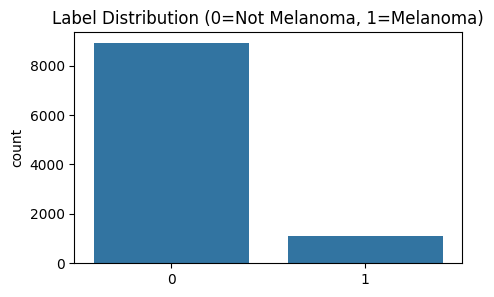

In [ ]:
# Visualize label distribution
plt.figure(figsize=(5,3))
sns.countplot(x=labels)
plt.title("Label Distribution (0=Not Melanoma, 1=Melanoma)")
plt.show()

In [ ]:
# Find indices for label 0 and label 1
idx_0 = np.where(labels == 0)[0][:3]
idx_1 = np.where(labels == 1)[0][:3]
sample_indices = np.concatenate([idx_0, idx_1])

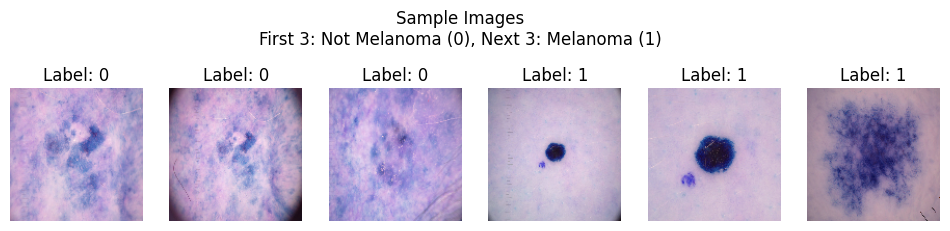

In [ ]:
# Show images: first 3 Not-Melanoma (0), next 3 Melanoma (1)
plt.figure(figsize=(12,3))
for i, idx in enumerate(sample_indices):
    plt.subplot(1,6,i+1)
    plt.imshow(data[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis("off")
plt.suptitle("Sample Images\nFirst 3: Not Melanoma (0), Next 3: Melanoma (1)")
plt.show()

In [ ]:
# TRAIN-VALIDATION SPLIT
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=SEED)
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 8012, Validation samples: 2003


In [ ]:
# DATA AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)

In [ ]:
# CLASS WEIGHTS (FOR FN REDUCTION)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.562482448750351), 1: np.float64(4.501123595505618)}


In [ ]:
# CNN SCRATCH MODEL
import tensorflow as tf
from tensorflow.keras import layers, models

print("CNN Scratch Model Architecture Description:")
print("""
- 3x Conv2D (32, 64, 128) layers with ReLU
- 3x MaxPooling layers for spatial reduction
- Flatten, Dense(128, relu), Dropout(0.5), Output(Dense(1, sigmoid))
- Input size: (128,128,3)
- Optimizer: Adam, Loss: Binary Crossentropy
""")

cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

CNN Scratch Model Architecture Description:

- 3x Conv2D (32, 64, 128) layers with ReLU
- 3x MaxPooling layers for spatial reduction
- Flatten, Dense(128, relu), Dropout(0.5), Output(Dense(1, sigmoid))
- Input size: (128,128,3)
- Optimizer: Adam, Loss: Binary Crossentropy



In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights_dict
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.4650 - loss: 0.6769 - val_accuracy: 0.7184 - val_loss: 0.6798
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.6359 - loss: 0.6177 - val_accuracy: 0.7229 - val_loss: 0.4671
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.6472 - loss: 0.5826 - val_accuracy: 0.6635 - val_loss: 0.5396
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.6236 - loss: 0.5483 - val_accuracy: 0.6950 - val_loss: 0.4999
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.6887 - loss: 0.5241 - val_accuracy: 0.6880 - val_loss: 0.5006
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.6794 - loss: 0.5255 - val_accuracy: 0.6585 - val_loss: 0.5124
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6655 - loss: 0.5155 - val_accuracy: 0.6121 - val_loss: 0.5549
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.6530 - loss: 0.5102 - val_accu

In [ ]:
# CNN Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

threshold = 0.4  # threshold tuning to reduce FN
y_pred_prob_cnn = cnn_model.predict(X_val)
y_pred_cnn = (y_pred_prob_cnn > threshold).astype(int)

print("CNN Classification Report (Threshold=0.4):\n", classification_report(y_val, y_pred_cnn))

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step
CNN Classification Report (Threshold=0.4):
               precision    recall  f1-score   support

           0       0.97      0.67      0.80      1780
           1       0.25      0.86      0.39       223

    accuracy                           0.69      2003
   macro avg       0.61      0.77      0.59      2003
weighted avg       0.89      0.69      0.75      2003



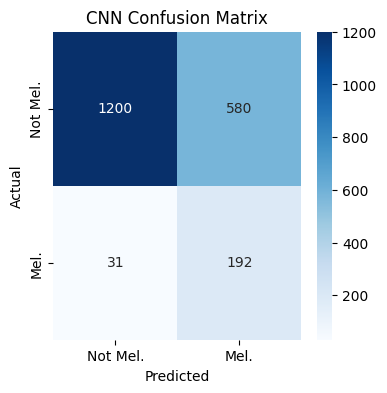

In [ ]:
# Confusion matrix
cm_cnn = confusion_matrix(y_val, y_pred_cnn)
plt.figure(figsize=(4,4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Mel.','Mel.'], yticklabels=['Not Mel.','Mel.'])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

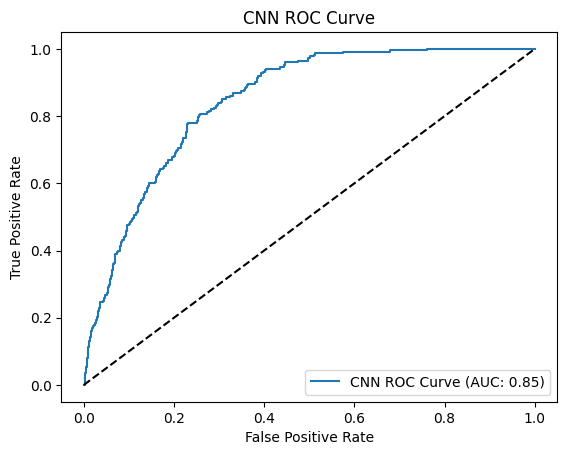

In [ ]:
# ROC curve
fpr_cnn, tpr_cnn, _ = roc_curve(y_val, y_pred_prob_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN ROC Curve (AUC: {auc_cnn:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("CNN ROC Curve")
plt.show()

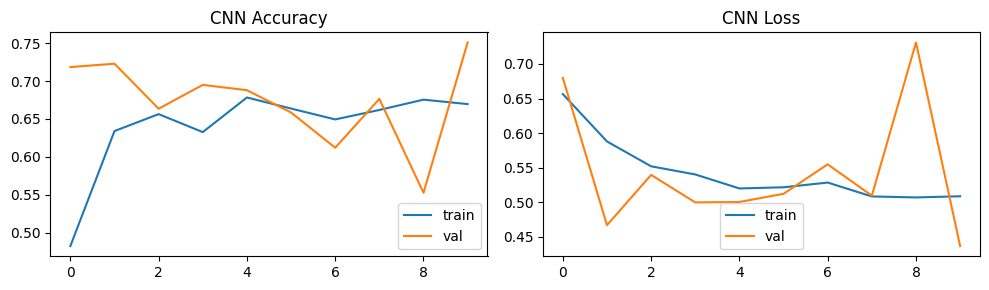

In [ ]:
# Plot training history
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label="train")
plt.plot(history_cnn.history['val_accuracy'], label="val")
plt.title("CNN Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label="train")
plt.plot(history_cnn.history['val_loss'], label="val")
plt.title("CNN Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# TRANSFER LEARNING MODEL
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

print("Transfer Learning Model (EfficientNetB0) Description:")
print("""
- Base: EfficientNetB0 (pre-trained on ImageNet)
- Top: GlobalAveragePooling, Dropout(0.3), Dense(1,sigmoid)
- Freeze all EfficientNetB0 layers (feature extraction)
- Optimizer: Adam, Loss: Binary Crossentropy
- Input size: (128,128,3)
""")

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE,3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

Transfer Learning Model (EfficientNetB0) Description:

- Base: EfficientNetB0 (pre-trained on ImageNet)
- Top: GlobalAveragePooling, Dropout(0.3), Dense(1,sigmoid)
- Freeze all EfficientNetB0 layers (feature extraction)
- Optimizer: Adam, Loss: Binary Crossentropy
- Input size: (128,128,3)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tl_model = models.Model(inputs, outputs)
tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tl_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history_tl = tl_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights_dict
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 242s 915ms/step - accuracy: 0.4738 - loss: 0.7164 - val_accuracy: 0.1113 - val_loss: 0.7189
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 226s 901ms/step - accuracy: 0.5507 - loss: 0.6931 - val_accuracy: 0.1113 - val_loss: 0.8604
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 225s 898ms/step - accuracy: 0.4106 - loss: 0.7299 - val_accuracy: 0.8887 - val_loss: 0.6360
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 221s 883ms/step - accuracy: 0.6119 - loss: 0.6853 - val_accuracy: 0.1113 - val_loss: 0.7057
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 224s 894ms/step - accuracy: 0.5217 - loss: 0.6890 - val_accuracy: 0.8887 - val_loss: 0.6811
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 226s 901ms/step - accuracy: 0.4288 - loss: 0.7140 - val_accuracy: 0.1113 - val_loss: 0.8746
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 229s 909ms/step - accuracy: 0.4666 - loss: 0.7030 - val_accuracy: 0.8887 - val_loss: 0.5711
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 228s 911ms/step - accuracy: 0.5473 -

In [ ]:
# Transfer Learning Evaluation
y_pred_prob_tl = tl_model.predict(X_val)
y_pred_tl = (y_pred_prob_tl > threshold).astype(int)
print("Transfer Learning Classification Report (Threshold=0.4):\n", classification_report(y_val, y_pred_tl))

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 748ms/step
Transfer Learning Classification Report (Threshold=0.4):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1780
           1       0.11      1.00      0.20       223

    accuracy                           0.11      2003
   macro avg       0.06      0.50      0.10      2003
weighted avg       0.01      0.11      0.02      2003



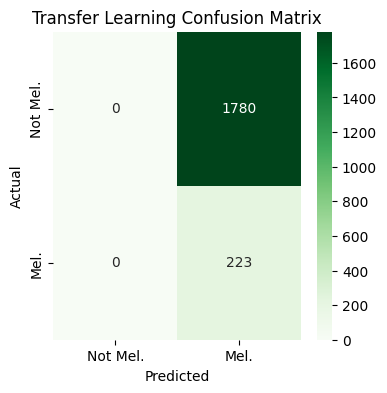

In [ ]:
cm_tl = confusion_matrix(y_val, y_pred_tl)
plt.figure(figsize=(4,4))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Mel.','Mel.'], yticklabels=['Not Mel.','Mel.'])
plt.title("Transfer Learning Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

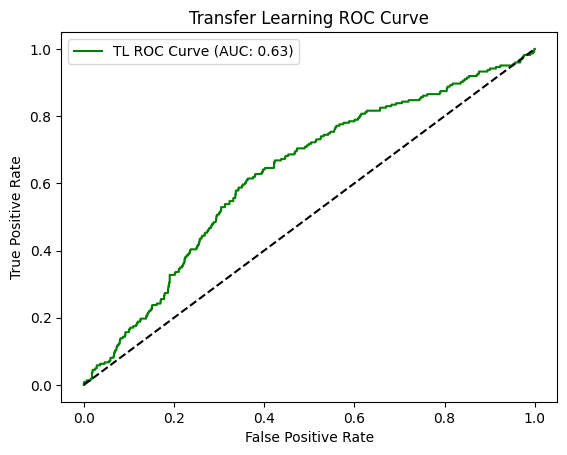

In [ ]:
fpr_tl, tpr_tl, _ = roc_curve(y_val, y_pred_prob_tl)
auc_tl = auc(fpr_tl, tpr_tl)
plt.figure()
plt.plot(fpr_tl, tpr_tl, label=f"TL ROC Curve (AUC: {auc_tl:.2f})", color='green')
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Transfer Learning ROC Curve")
plt.show()

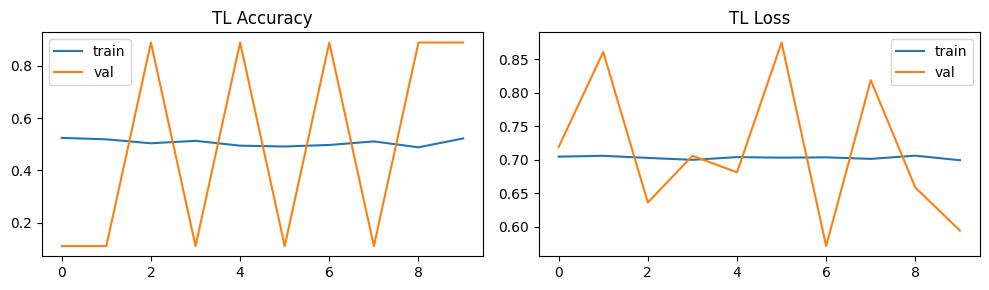

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(history_tl.history['accuracy'], label="train")
plt.plot(history_tl.history['val_accuracy'], label="val")
plt.title("TL Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_tl.history['loss'], label="train")
plt.plot(history_tl.history['val_loss'], label="val")
plt.title("TL Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# SAVE BOTH MODELS
os.makedirs('./outputs', exist_ok=True)
cnn_model.save('./outputs/cnn_scratch.keras')
print("✅ CNN scratch model saved as cnn_scratch.keras")
tl_model.save('./outputs/ham10000_transfer_learning.keras')
print("✅ Transfer Learning model saved as ham10000_transfer_learning.keras")


✅ CNN scratch model saved as cnn_scratch.keras
✅ Transfer Learning model saved as ham10000_transfer_learning.keras


In [ ]:
base_model = tl_model.get_layer('efficientnetb0')
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


0 input_layer_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activa

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

IMG_SIZE = 128   # EfficientNetB0 expects 224x224

# ------------------------------
# 1) Load EfficientNetB0 Backbone
# ------------------------------
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze backbone
base_model.trainable = False

# ------------------------------
# 2) Add custom classifier
# ------------------------------
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

# ------------------------------
# 3) Grad-CAM Function
# ------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


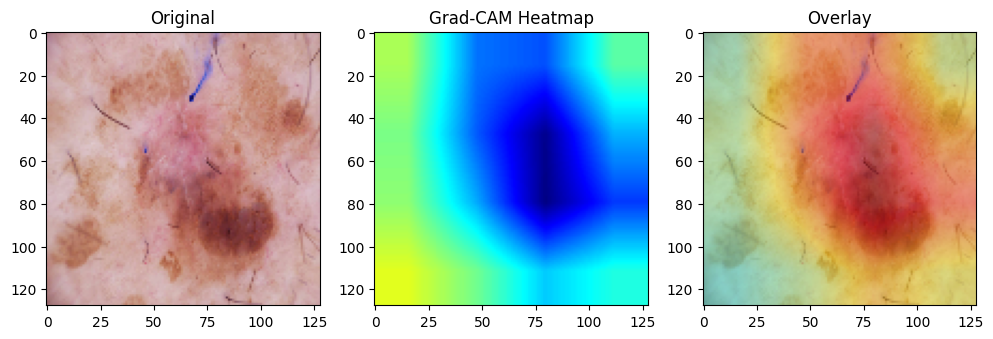

In [ ]:
# ------------------------------
# 4) Load & Preprocess Image
# ------------------------------
img_path = "/content/ham10000/HAM10000_images_part_1/ISIC_0024515.jpg"  # <-- replace
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# ------------------------------
# 5) Generate Heatmap
# ------------------------------
last_conv_layer_name = "top_conv"  # last conv layer in EfficientNetB0
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# ------------------------------
# 6) Superimpose Heatmap
# ------------------------------
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# ------------------------------
# 7) Show Results
# ------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Grad-CAM Heatmap")
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)); plt.title("Overlay")
plt.show()